In [1]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True)  #important for L-BFGS

import jax
import jax.numpy as np

import pylab as plt
import imageio
import os
import numpy as onp
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import scipy

# Exercise 2: Image Deblurring

Load the image `film.png` and restore it as well as you can.  

**Remark**: if you use `L-BFGS` for image processing, it may be a good idea to set the tolerance to a low value i.e. to use the option `tol=10**-8` or something of that order

(-0.5, 299.5, 241.5, -0.5)

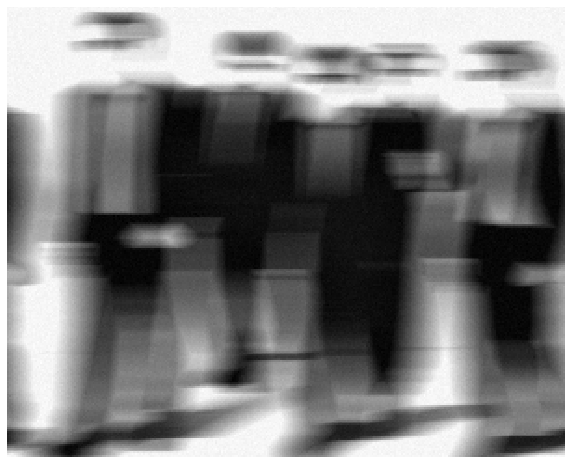

In [2]:
#load image
path_img = "./film.png"
im_blurred = onp.array(imageio.imread(path_img).astype(float))/255.

#display
plt.figure(figsize=(10,10))
plt.imshow(im_blurred, cmap="gray")
plt.axis("off")

To do so, you can assume that this noisy image has been obtained by using the following process.

In [3]:
def blurr(im):
    S = np.zeros_like(im) 
    for k in range(30):
        S += np.roll(im, shift=(k+1), axis=1) # shift array elements along horizontal axis.
    return S/30.

In [5]:
#for some unkown clean image "im_clean"
#im_blurred = blurr(im_clean) + onp.random.normal(0,0.01,size=im_clean.shape)

#your job is to find back a good estimate of this unknown clean image.

$$g(x) = h(x)*f(x)+n(x), \ x=(u,v)\in\Omega$$ where $\Omega \subset \mathbb{R}^2$ is the support of the image, and $f(x),g(x),h(x),n(x)$ denote the original, observed images, the blur operator and additive noise respectively.

Estimate $f(x,y)$ by optimising a cost function:
$$\hat{f} = \text{argmin}_f(g-Af)^2+\lambda p(f)$$

Here, $g$ is the observed image and $A$ is the generated image.

e.g. $p(f)=(\nabla f)^2$

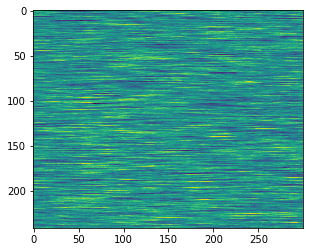

In [23]:
w, h = im_blurred.shape
r = 100
U_init = onp.random.normal(0,1,size=(w,r)) / onp.sqrt(w*r)
V_init = onp.random.normal(0,1,size=(r,h)) / onp.sqrt(h*r)

plt.imshow(blurr(U_init @ V_init))

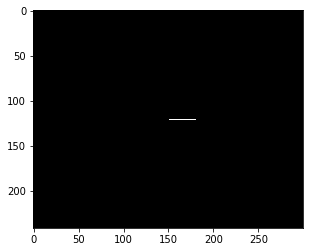

In [10]:
# estimate point spread function (PSF)
P = onp.zeros(shape=im_blurred.shape)
P[round(w/2),round(h/2)] = 1.
plt.imshow(blurr(P), cmap='gray')

Gradient Descent above doesn't do very well, and takes a long time to train.

## L-BFGS

In [14]:
def loss(U,V):
    return np.mean((im_blurred - blurr(U @ V))**2)

grad_loss_u = jax.jit(jax.grad(loss, argnums=0))
grad_loss_v = jax.jit(jax.grad(loss, argnums=1))

In [15]:
#note that LBFGS expects vectors, not matrices --> we have to flatten everything
def minimize_U_fixed(U,V, LBFGS_iter):
    def grad_v_wrapper(V_flat):
        V = V_flat.reshape(r,h)
        return onp.array(grad_loss_v(U,V)).ravel()
    
    def loss_wrapper(V_flat):
        V = V_flat.reshape(r,h)
        return loss(U,V)
    
    traj = scipy.optimize.minimize(fun = loss_wrapper, #functino to minimize
                                x0 = onp.array(V.ravel()), #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                tol=10**-8,
                                jac=grad_v_wrapper, #function that computes the gradient
                                options={"maxiter":LBFGS_iter})  #maximum number of iteration
    V_final = traj["x"].reshape(r,h)
    return V_final


#let us define a function that does a few steps of LBFGS with V fixed
def minimize_V_fixed(U,V, LBFGS_iter):
    def grad_v_wrapper(U_flat):
        U = U_flat.reshape(w,r)
        return onp.array(grad_loss_u(U,V)).ravel()
    
    def loss_wrapper(U_flat):
        U = U_flat.reshape(w,r)
        return loss(U,V)
    
    traj = scipy.optimize.minimize(fun = loss_wrapper, #functino to minimize
                                x0 = onp.array(U.ravel()), #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                tol=10**-8,
                                jac=grad_v_wrapper, #function that computes the gradient
                                options={"maxiter":LBFGS_iter})  #maximum number of iteration
    U_final = traj["x"].reshape(w,r)
    return U_final

In [16]:
U,V = onp.copy(U_init), onp.copy(V_init)

In [17]:
LBFGS_iter = 10000
n_iter = 500
loss_history = []

for _ in range(n_iter):
    V = minimize_U_fixed(U,V, LBFGS_iter)
    U = minimize_V_fixed(U,V, LBFGS_iter)
    loss_history.append(loss(U,V))

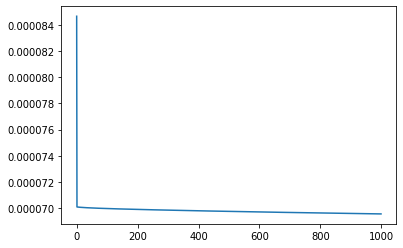

In [18]:
plt.plot(loss_history)

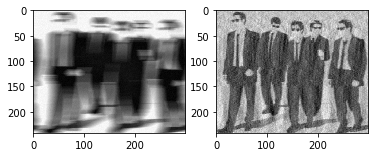

In [25]:
plt.subplot(1,2,1)
plt.imshow(im_blurred, cmap="gray")

plt.subplot(1,2,2)
plt.imshow(U@V, cmap="gray")

In [20]:
# final loss
loss_history[-1]

DeviceArray(6.95677735e-05, dtype=float64)

**L-BFGS Results**

BFGS_iter = 5000, n_iter = 100, no regularisation, loss = 7.32537508e-05 

same as 1st but 0.1 abs() regularisation, loss = 0.05

same as 1st but 0.1 ^2 regularisation, loss=3.41e-03

(-0.5, 299.5, 241.5, -0.5)

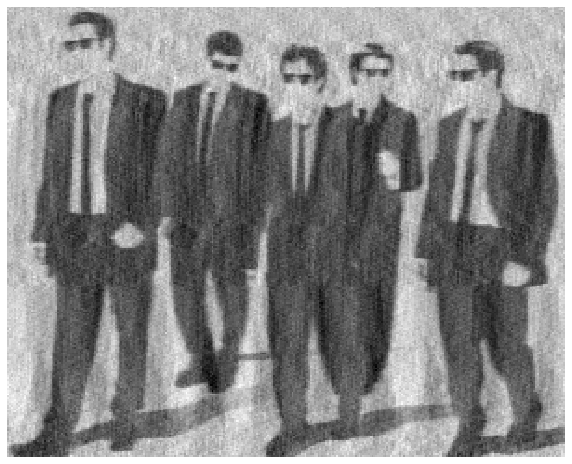

In [28]:
# no regularisation
plt.figure(figsize=(10,10))
plt.imshow(U@V, cmap="gray")
plt.axis("off")